# Landing gear model
**Group 07 - Girardi Gabriele (03801158) ** 

## TASK:
- Model the system under the simulation project constraints
- Find suitable parameters for your model
- Perform a time integration of the system to determine the reaction forces during landing


_
<img src="./figures/Suspension.png" width="500"/>

### Reference plane for finding suitable parameters 

Beechcraft Bonanza

<img src="./figures/Beechcraft_Bonanza_plane.jpg" width="500"/>

### Solution procedure overview
1. Kinetic and potential energy of the system
2. Kinematic analysis for relating minimal coordinates with suspension strut length and angle 
3. Evaluation of dissipation moments (viscous friction) on the joints
4. Suspension modeling
5. Contact and tyre elastic/damped behaviour model
6. Landing phase modeling
7. Simplified model for the suspension actions
8. EOMs, parameters substitution and time integration of the statespace. 
9. Plots of minimal coordinates and first/second derivatives
10. Forces on the tyre
11. Mechanism animation (with external script)
12. Reaction forces and moments

# Schematic of the system


<img src="./figures/Schematic1.png" width="600"/>

## PART 1: system EOMs with Lagrange's equations

In [1]:

import sympy as sy
from sympy import cos, sin
from sympy.physics.mechanics import init_vprinting
import numpy as np

init_vprinting()

### Definition of required symbols, functions and geometrical parameters

In [2]:
# time 
t = sy.Symbol('t')

# minimal coordinates
phi = sy.Function('phi')(t)
beta = sy.Function('beta')(t)

q = sy.Matrix([phi, beta])
dq = sy.diff(q, t)
ddq = sy.diff(dq, t)

# mass and inertia parameters
m_r, m_w, A, B, C, D = sy.symbols(' m_r m_w A B C D')
Theta_r = sy.diag(A, B, A)
Theta_w = sy.diag(C, C, D)

# geometric quantities (length_rod, radius_wheel, lever_arm)
# (please note that contact force on the wheel is not in the same plane as the rod. It is needed to define a lever arm)
l_r, r_w, l_a = sy.symbols('l_r r_w l_a')

# friction coefficients at joints
d_phi, d_beta = sy.symbols('d_phi d_beta')

# gravity
g = sy.Symbol('g')
g_vec = sy.Matrix([0, -g, 0])

# check
display(Theta_r, Theta_w, ddq)


⎡A  0  0⎤
⎢       ⎥
⎢0  B  0⎥
⎢       ⎥
⎣0  0  A⎦

⎡C  0  0⎤
⎢       ⎥
⎢0  C  0⎥
⎢       ⎥
⎣0  0  D⎦

⎡φ̈⎤
⎢ ⎥
⎣β̈⎦

### Calculation of kinetic energy $\cal T$ and potential energy $\cal V$ of the system

#### Kinematic analysis

In [3]:
# position vectors (hypotesis: position of wheel center of mass is vertically aligned with contact force, so we localize it using lever arm)
I_r_r = sy.Matrix([l_r/2*sin(phi), -l_r/2*cos(phi), 0])
I_r_w = sy.Matrix([l_r*sin(phi), -l_r*cos(phi), -l_a])

# rotation matrixes between coordinate systems
r_A_I = sy.Matrix([[cos(phi), sin(phi), 0],
                   [-sin(phi), cos(phi), 0],
                   [0, 0, 1]
                   ])
w_A_r = sy.Matrix([[cos(phi), -sin(phi), 0],
                   [sin(phi), cos(phi), 0],
                   [0, 0, 1]
                   ])
# translational velocities
I_dr_r = sy.diff(I_r_r, t)
I_dr_w = sy.diff(I_r_w, t)

# absolute angular velocities
r_omega_r = sy.Matrix([0, 0, phi.diff(t)])
w_omega_beta = sy.Matrix([0, 0, beta.diff(t)])
w_omega_phi = w_A_r @ r_omega_r
w_omega_w = w_omega_beta + w_omega_phi

# check
display(I_r_r, I_r_w, r_A_I, w_A_r, I_dr_r, I_dr_w, r_omega_r, w_omega_beta, w_omega_phi, w_omega_w)

⎡ lᵣ⋅sin(φ) ⎤
⎢ ───────── ⎥
⎢     2     ⎥
⎢           ⎥
⎢-lᵣ⋅cos(φ) ⎥
⎢───────────⎥
⎢     2     ⎥
⎢           ⎥
⎣     0     ⎦

⎡lᵣ⋅sin(φ) ⎤
⎢          ⎥
⎢-lᵣ⋅cos(φ)⎥
⎢          ⎥
⎣   -lₐ    ⎦

⎡cos(φ)   sin(φ)  0⎤
⎢                  ⎥
⎢-sin(φ)  cos(φ)  0⎥
⎢                  ⎥
⎣   0       0     1⎦

⎡cos(φ)  -sin(φ)  0⎤
⎢                  ⎥
⎢sin(φ)  cos(φ)   0⎥
⎢                  ⎥
⎣  0        0     1⎦

⎡lᵣ⋅cos(φ)⋅φ̇⎤
⎢───────────⎥
⎢     2     ⎥
⎢           ⎥
⎢lᵣ⋅sin(φ)⋅φ̇⎥
⎢───────────⎥
⎢     2     ⎥
⎢           ⎥
⎣     0     ⎦

⎡lᵣ⋅cos(φ)⋅φ̇⎤
⎢           ⎥
⎢lᵣ⋅sin(φ)⋅φ̇⎥
⎢           ⎥
⎣     0     ⎦

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣φ̇⎦

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣β̇⎦

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣φ̇⎦

⎡  0  ⎤
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣β̇ + φ̇⎦

#### Kinetic and potential energy of the system

In [4]:
# kinetic energy of the rod
T_r = sy.Matrix([(0.5 * m_r * I_dr_r.T * I_dr_r) + 
                 (0.5 * r_omega_r.T @ Theta_r @ r_omega_r)])
T_r.simplify()

# kinetic energy of the wheel
T_w = sy.Matrix([(0.5 * m_w * I_dr_w.T * I_dr_w) + 
                 (0.5 * w_omega_w.T @ Theta_w @ w_omega_w)])
T_w.simplify()

# kinetic energy of the system
T = T_r + T_w
T.simplify()

# potential energy of the rod
U_r = -m_r * g_vec.T * I_r_r

# potential energy of the wheel
U_w = -m_w * g_vec.T * I_r_w

# potential energy of the system
U = U_r + U_w
U.simplify()

# check
display(T_r, T_w, T, U_r, U_w, U)

⎡⎛                2   ⎞  2⎤
⎣⎝0.5⋅A + 0.125⋅lᵣ ⋅mᵣ⎠⋅φ̇ ⎦

⎡       2                      2         2      2⎤
⎣0.5⋅D⋅β̇  + 1.0⋅D⋅β̇⋅φ̇ + 0.5⋅D⋅φ̇  + 0.5⋅lᵣ ⋅m_w⋅φ̇ ⎦

⎡       2                      2         2      2   ⎛                2   ⎞  2⎤
⎣0.5⋅D⋅β̇  + 1.0⋅D⋅β̇⋅φ̇ + 0.5⋅D⋅φ̇  + 0.5⋅lᵣ ⋅m_w⋅φ̇  + ⎝0.5⋅A + 0.125⋅lᵣ ⋅mᵣ⎠⋅φ̇ ⎦

⎡-g⋅lᵣ⋅mᵣ⋅cos(φ) ⎤
⎢────────────────⎥
⎣       2        ⎦

[-g⋅lᵣ⋅m_w⋅cos(φ)]

⎡g⋅lᵣ⋅(-mᵣ - 2⋅m_w)⋅cos(φ)⎤
⎢─────────────────────────⎥
⎣            2            ⎦

### Defining relation between minimal coordinate angle $\phi$ and length of the suspension strut $l_s$

A useful reference for following the implementation is the following schematic

<img src="./figures/Schematic2.jpeg" width="500"/>



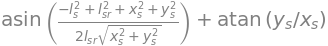

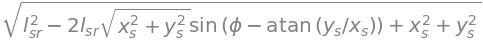

In [5]:
# localizing strut anchor point on the frame wrt inertial coordinate system
x_s, y_s = sy.symbols('x_s y_s')
r_s = sy.Matrix([x_s, y_s, 0])

# evaluating angle between line passing through inertia frame and strut anchor point
fixangle = sy.atan(y_s/x_s)

# evaluating distance between inertia frame and strut anchor point
fixdistance = sy.sqrt(x_s**2 + y_s**2)

# defining strut length
#l_s = sy.Function('l_s')(t)
l_s = sy.Symbol('l_s')

# defining distance from strut anchor point on the rod and inertia frame (length strut-rod)
l_sr = sy.Symbol('l_{sr}')

# exploiting cosine theorem
costheorem = l_s**2 - fixdistance**2 - l_sr**2 + 2*fixdistance*l_sr*cos(sy.pi/2 + fixangle - phi)
#display(costheorem)

# getting expression for both phi and l_s
phi_l_s = sy.solve(costheorem, phi)[0]
l_s_phi = - sy.solve(costheorem, l_s)[0]

display(phi_l_s, l_s_phi)

### Evaluating angle of force exchange between rod and suspension strut
Of course when the suspension strut changes its length, the entire mechanism configuration is changed. The rod will rotate, and consequently also the strut itself will rotate. The angle of force exchange between the two members is therefore dependent on the length of the suspension strut.

**PLEASE NOTE:**

Since we want to solve the equations with $\phi$, we express the angle wrt to it 

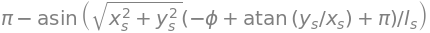

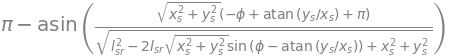

In [6]:
# defining angle of force exchange
force_exchange_angle = sy.Symbol('°f_{ex}')

# Exploiting the sine theorem -> force exchange angle is the angle between rod y axis and strut
sintheorem = fixdistance - (l_s/(sy.pi + fixangle - phi)) * sin(force_exchange_angle)

force_exchange_angle = sy.solve(sintheorem, force_exchange_angle)[0]
display(force_exchange_angle) 

# substituting the expression for l_s -> ANGLE AS A FUNCTION OF PHI
force_exchange_angle = force_exchange_angle.subs([(l_s, l_s_phi)])
force_exchange_angle.simplify()

display(force_exchange_angle)

### Dissipation moments on the joints

In [7]:
# jacobians of rotations 
r_Jr = r_omega_r.jacobian(dq)
w_Jr = w_omega_w.jacobian(dq)

# friction torques
dphi = phi.diff(t)
dbeta = beta.diff(t)

M_phi = - d_phi * dphi
M_beta = - d_beta * dbeta

# torques wrt the center of mass of the bodies
r_M_cr = sy.Matrix([0, 0, M_phi])
w_M_cw = sy.Matrix([0, 0, M_beta])

# dissipation moments
moments_diss = r_Jr.T @ r_M_cr + w_Jr.T @ w_M_cw

# check
display(r_M_cr, w_M_cw, r_Jr, w_Jr, moments_diss)

⎡  0  ⎤
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣-dᵩ⋅φ̇⎦

⎡  0  ⎤
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣-dᵦ⋅β̇⎦

⎡0  0⎤
⎢    ⎥
⎢0  0⎥
⎢    ⎥
⎣1  0⎦

⎡0  0⎤
⎢    ⎥
⎢0  0⎥
⎢    ⎥
⎣1  1⎦

⎡-dᵦ⋅β̇ - dᵩ⋅φ̇⎤
⎢            ⎥
⎣   -dᵦ⋅β̇    ⎦

### Suspension forces

Since the suspension is composed of both a spring and a damper, that represent a non conservative force term, we prefer to not split the 2 parts inserting the spring component of the force into the potential energy expression above, but instead we will treat them both into the non conservative terms $\vec{Q}^\text{nc}$. This will also keep the code cleaner.


**Suspension force:**
$F_{s} = - k_{s}\cdot(l_0 - l_s) - c_{s}\cdot\dot{(l_0-l_s)}$

**NOTE:**

Since the suspension force is not acting in the center of mass of the rod, when moving it to the CM it is of course required to add a torque, for the new system to be equivalent. We will have therefore a moment $M_s = (F_{sx} \cdot cos(\phi) + F_{sy} \cdot sin(\phi)) \cdot (l_{sr} - \frac{l_r}{2})$, where $l_{sr}$ has been defined above as the distance between inertia frame and strut anchor point on the rod. Please note that the suspension force is not orthogonal to the rod but its direction has an angle computed above. So the simple $M_s = F_s \cdot (l_{sr} - \frac{l_r}{2})$ would not give the correct result. Also, note that the moment is CLOCKWISE

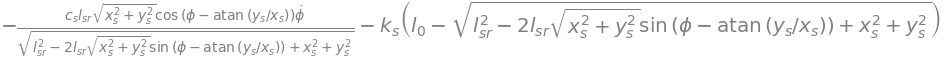

In [8]:
# symbols definition
k_s, c_s, l0 = sy.symbols('k_s c_s l_0')
dx_s = l0 - l_s_phi
ddx_s = sy.diff(dx_s, t)

# suspension force 
F_s = - k_s*dx_s - c_s*ddx_s

# check
display(F_s)


It is now required to express force and moment from the suspension in vector form. For the force, the angle of force exchange (angle between y axis of the rod and suspension axis) has been computed above and is a function of the minimal coordinates. It is required though to express the vector wrt the inertia frame. The exchange angle can be expressed wrt the inertia frame, with:
$I(exchange angle) = \pi - (exchange angle + \frac{\pi}{2} - \phi)$

In [9]:
# expressing exchange angle wrt inertia frame
I_force_exchange_angle = sy.pi - (force_exchange_angle + sy.pi/2 - phi)

# force on the center of mass of the rod
I_F_s_x = - F_s * cos(I_force_exchange_angle)
I_F_s_y = - F_s * sin(I_force_exchange_angle)

I_F_s_cm = sy.Matrix([I_F_s_x, I_F_s_y, 0])

# It is now possible to define moment (its negative -> clockwise)
M_s = (I_F_s_x * sin(phi) + I_F_s_y * cos(phi) * (l_sr-l_r/2))

# moment wrt center of mass of the rod
r_M_s_cr = sy.Matrix([0, 0, M_s])

# projecting the moment using the jacobian of rotations
M_susp = r_Jr.T @ r_M_s_cr

# jacobian of translations for the rod
r_Jt = I_r_r.jacobian(q)

# projecting suspension force 
F_susp = r_Jt.T @ I_F_s_cm

# check
display(M_susp, F_susp)

⎡                  ⎛                          ___________                     
⎢                  ⎜                         ╱   2     2     ⎛        ⎛yₛ⎞⎞   
⎢                  ⎜            cₛ⋅l_{sr}⋅╲╱  xₛ  + yₛ  ⋅cos⎜φ - atan⎜──⎟⎟⋅φ̇ 
⎢  ⎛  lᵣ         ⎞ ⎜                                         ⎝        ⎝xₛ⎠⎠   
⎢- ⎜- ── + l_{sr}⎟⋅⎜──────────────────────────────────────────────────────────
⎢  ⎝  2          ⎠ ⎜     _____________________________________________________
⎢                  ⎜    ╱                       ___________                   
⎢                  ⎜   ╱        2              ╱   2     2     ⎛        ⎛yₛ⎞⎞ 
⎢                  ⎜  ╱   l_{sr}  - 2⋅l_{sr}⋅╲╱  xₛ  + yₛ  ⋅sin⎜φ - atan⎜──⎟⎟ 
⎢                  ⎝╲╱                                         ⎝        ⎝xₛ⎠⎠ 
⎢                                                                             
⎣                                                                             

                                                   

⎡   ⎛                          ___________                                    
⎢   ⎜                         ╱   2     2     ⎛        ⎛yₛ⎞⎞                  
⎢   ⎜            cₛ⋅l_{sr}⋅╲╱  xₛ  + yₛ  ⋅cos⎜φ - atan⎜──⎟⎟⋅φ̇                
⎢   ⎜                                         ⎝        ⎝xₛ⎠⎠                  
⎢lᵣ⋅⎜────────────────────────────────────────────────────────────────────── + 
⎢   ⎜     _________________________________________________________________   
⎢   ⎜    ╱                       ___________                                  
⎢   ⎜   ╱        2              ╱   2     2     ⎛        ⎛yₛ⎞⎞     2     2    
⎢   ⎜  ╱   l_{sr}  - 2⋅l_{sr}⋅╲╱  xₛ  + yₛ  ⋅sin⎜φ - atan⎜──⎟⎟ + xₛ  + yₛ     
⎢   ⎝╲╱                                         ⎝        ⎝xₛ⎠⎠                
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                   

### Contact model, tyre elasticity and damping, and landing simulation

1. **CONTACT AND TYRE MODELING**

Contact will be modeled with a regularized approach, as seen in the lecture. Since the tyre will also have an elasticity described by the coefficient $ k_{ty} $, the overall elasticity of the contact should be modeled as 2 springs in series.

Please note that the instead of ($ k_{contact} = \frac{k_{gr} \cdot k_{tyre}}{k_{gr}+k_{tyre}} $), since $k_{gr} >> k_{tyre}$, the reasonable approximation $k_{contact} \approx k_{tyre} $ has been used.

Furthermore, in a real landing situation ground and wheel center of mass have of course a relative velocity. This will cause a **tangential force on the tyre during contact, causing the wheel to spin**. The tangential force can be expressed as $ F_{tang} = F_{norm} \cdot \mu $. This force will act until the wheel tangential acceleration has reached the **no slip** condition, where the relative velocity between tyre and ground is zero. After that, only a torque to balance the dissipation torque in the bearing will be generated. 

Please note that adding this no slip condition to the moment piecewise defined equation below increases a lot the complexity, since a second condition (apart the one on the distance h that signals the presence or not of the contact) accounting for the velocity needs to be added. Looking closely, this condition doesn't yield any new result for us. We can simply perform the time integration without it, having care to manually make the right modifications to the vector of the solutions z_vec afterwards.

**RECAP SIMPLIFICATIONS for CONTACT:**
1. $k_{contact} \approx k_{tyre} $
2. No *no slip* condition is added to the moment equation, but a function will be created to account for that directly after having solved the EOMs 

--------------------------------------------------------------------------------------------------------------

2. **LANDING PHASE (TOUCHDOWN) MODELING**

The simplest approach for modeling the landing is to **express the distance between inertia frame of the suspension and ground as a function of time**. This function can take different forms, such as linear, quadratic, exponential... Furthermore, we could also define some function for the **descent velocity** (touchdown velocity) or using some real-world data and integrate it for the position.

To remain simple, here we will implement a simple linear model for the descent, keeping the descent velocity as a constant. Mathematically:

$h(t) = h_0 - v_{descent} \cdot t$

It is important to implement also a stop condition. **When should the ground (the plane) stop going up (going down) towards the suspension (the ground)? When the entire weight of the plane is transferred to the ground through the suspension**(since the rod pin cannot transmit any vertical load to the ground).

It gets difficult to impose on the landing descent model a condition on a force, which can only be obtained post processing the solution of the EOMs. Since it is the spring part of the suspension that transmits the load though, we can translate this condition on the force to a kinematic one pretty easily. In particular, **it is required that the y component of the force through the suspension equals the mass of the plane**.

Please note that the plane will have at least 3 wheels on which redistribute its load. We consider it a small plane from the suspension picture provided, so the decide for 3 wheels, and since during landing the front wheel is not much used (if at all), we distribute the weight on only 2 suspension systems



In [10]:
# defining jacobian of translations for the wheel
w_Jt = I_r_w.jacobian(q)

# the plane is landing -> need a descent model
v_desc = sy.Symbol('v_{desc}')
h0 = sy.Symbol('h_0')
# linear descent model
h_linear_model = h0 - v_desc * t

# need a stop condition -> THIS IMPLEMENTATION IS BASED ON THE SIMPLIFIED MODEL OF THE SUSPENSION
mass_plane = sy.Symbol('m_{plane}')
phi_ref = sy.Symbol('phi_{ref}')

deltax_full_load = (mass_plane/2 * g) / k_s     # weight divided on 2 wheels
stop_height_suspension_anchor_point = (- l_sr * cos(phi_ref) + deltax_full_load)
stop_angle = sy.acos(-stop_height_suspension_anchor_point/l_sr)

# position of the hub at the stopping point, minus radius of the wheel
# WHEEL RADIUS DOESN'T STAY CONSTANT, since wheel is elastic!! Need to compensate
compensation = 0.07
stop_height_ground = sy.Abs(-l_r * cos(stop_angle) - (r_w-compensation))
stop_height_wheel_hub = stop_height_ground + r_w
h = sy.Piecewise((h_linear_model, h_linear_model>=stop_height_ground), (stop_height_ground, h_linear_model<stop_height_ground))


# distance between wheel hub and ground
distance = h + I_r_w[1]
display(distance)

# defining tyre and ground stiffness
k_ty = sy.Symbol('k_{ty}')
k_gr = sy.Symbol('k_{gr}')

# Approximation: using tyre elasticity
k_contact = k_ty

# tyre and ground equivalent elastic force
F_el = k_contact * (distance - r_w)

# defining tyre damping coefficient
d_ty = sy.Symbol('d_{ty}')

# tyre damping force
F_damp =  d_ty * I_dr_w[1]

# piecewise function for the contact reaction force (ground, tyre k and d)
F_ct = sy.Piecewise((F_el + F_damp, distance <= r_w), (0, distance > r_w))

# as vector
F_ground = sy.Matrix([0, F_ct, 0])

# projecting F_ground with the Jacobian of translations
F_ground = w_Jt.T @ F_ground 

# check
display(F_ground)

# defining friction coefficient between tyre and ground
mu = sy.Symbol('mu')

# defining relative velocity between airplane and ground during landing
vel_landing_x = sy.Symbol('v_{lanx}')

# Moment on the wheel when in contact
F_w_tan = mu * (F_el + F_damp)    # wheel rotates in clockwise dir
M_contact = F_w_tan * r_w

# ----------------------------------------------------------------------------
# !!!!! piecewise function for the moment -> TOO COMPLEX! 
# M_ct = sy.Piecewise((M_contact, (distance <= r_w) & (w_omega_w[2] * r_w < vel_landing)), (0, distance > r_w)) -> here another condition should be added -> w_M_cw, (distance <= r_w) & (w_omega_w[2] * r_w >= vel_landing)
# ---------------------------------------------------------------------------

# simplified function for the moment, disregarding for now the more complex conditions "no slip" (see the comment above)
M_ct = sy.Piecewise((M_contact, distance <= r_w), (0, distance > r_w))

# as vector
M_ground = sy.Matrix([0, 0, M_ct])

# projecting M_ground with the Jacobian of rotations
M_ground = w_Jr.T @ M_ground

# check
display(M_ground)

             ⎛⎧                                                               
             ⎜⎪                                                               
             ⎜⎪                                                               
             ⎜⎪                     h₀ - t⋅v_{desc}                       for 
             ⎜⎪                                                               
-lᵣ⋅cos(φ) + ⎜⎨                                                               
             ⎜⎪│     ⎛  g⋅m_{plane}                      ⎞             │      
             ⎜⎪│  lᵣ⋅⎜- ─────────── + l_{sr}⋅cos(φ_{ref})⎟             │      
             ⎜⎪│     ⎝      2⋅kₛ                         ⎠             │      
             ⎜⎪│- ──────────────────────────────────────── - r_w + 0.07│      
             ⎝⎩│                   l_{sr}                              │      

                  │     ⎛  g⋅m_{plane}                      ⎞             │⎞
                  │  lᵣ⋅⎜- ─────────── + l_{sr}⋅cos(φ

⎡   ⎛⎧                            ⎛                   ⎛⎧                      
⎢   ⎜⎪                            ⎜                   ⎜⎪                      
⎢   ⎜⎪                            ⎜                   ⎜⎪                      
⎢   ⎜⎪                            ⎜                   ⎜⎪                     h
⎢   ⎜⎪                            ⎜                   ⎜⎪                      
⎢   ⎜⎪d_{ty}⋅lᵣ⋅sin(φ)⋅φ̇ + k_{ty}⋅⎜-lᵣ⋅cos(φ) - r_w + ⎜⎨                     
⎢   ⎜⎪                            ⎜                   ⎜⎪│     ⎛  g⋅m_{plane}  
⎢   ⎜⎪                            ⎜                   ⎜⎪│  lᵣ⋅⎜- ─────────── +
⎢   ⎜⎪                            ⎜                   ⎜⎪│     ⎝      2⋅kₛ     
⎢   ⎜⎪                            ⎜                   ⎜⎪│- ───────────────────
⎢   ⎜⎪                            ⎝                   ⎝⎩│                   l_
⎢lᵣ⋅⎜⎨                                                                        
⎢   ⎜⎪                                              

⎡⎧      ⎛                            ⎛                   ⎛⎧                   
⎢⎪      ⎜                            ⎜                   ⎜⎪                   
⎢⎪      ⎜                            ⎜                   ⎜⎪                   
⎢⎪      ⎜                            ⎜                   ⎜⎪                   
⎢⎪      ⎜                            ⎜                   ⎜⎪                   
⎢⎪μ⋅r_w⋅⎜d_{ty}⋅lᵣ⋅sin(φ)⋅φ̇ + k_{ty}⋅⎜-lᵣ⋅cos(φ) - r_w + ⎜⎨                  
⎢⎪      ⎜                            ⎜                   ⎜⎪│     ⎛  g⋅m_{plane
⎢⎪      ⎜                            ⎜                   ⎜⎪│  lᵣ⋅⎜- ──────────
⎢⎪      ⎜                            ⎜                   ⎜⎪│     ⎝      2⋅kₛ  
⎢⎪      ⎜                            ⎜                   ⎜⎪│- ────────────────
⎢⎪      ⎝                            ⎝                   ⎝⎩│                  
⎢⎨                                                                            
⎢⎪                                                  

### Simplified model for the suspension forces
The approach used above is of course the most realistical, and models exactly the presence of the suspension strut and its effects. Nevertheless, it seems we are not able to get appropriate solutions in that way, with the problem being related to the kinematics of the suspension system. Indeed when solving using this model, an error related to the arcsin function argument being out of bounds is yielded from the lambdifyed expression, and the time integration procedure does not give any number as output

I therefore implement a simpler model here, as a plan B, until I figure out the error on the original one: let's consider the simplified case where the direction of the forces from the suspension strut is aligned with the vertical direction, and this does not change over time. In this case, the parameters of the suspension strut (length, anchor point to the frame etc) are not needed, except for the position of the anchor point (hinge) between strut and rod. The vertical displacement and its relative velocity, needed for the force of spring and damper, will be evaluated using angle $\phi$

**Suspension force:**
$F_{s} = - k_{s}\cdot(l_s - l_0) - c_{s}\cdot\dot{(l_s-l_0)}$

In [11]:
# symbols already defined above
#k_s, c_s= sy.symbols('k_s c_s')

#phi_ref = sy.Symbol('phi_{ref}')
y_ref = - l_sr * cos(phi_ref)
y = - l_sr * cos(phi)

dx_s_simplif_model =  y - y_ref

ddx_s_simplif_model = sy.diff(dx_s_simplif_model, t)
display(dx_s_simplif_model, ddx_s_simplif_model)

# suspension force 
F_s_simplif_model = - k_s*dx_s_simplif_model - c_s*ddx_s_simplif_model

# suspension moment about the center of mass (since hp suspension force is always in the vertical direction, expression is simpler than before)
M_s_simplif_model = F_s_simplif_model * (l_sr-l_r/2)*sin(phi)

display(F_s_simplif_model, M_s_simplif_model)




It is now required to transform force and moment into vectors and to project them using the Jacobian

In [12]:
# moment wrt center of mass of the rod
r_M_s_cr_simpmodel = sy.Matrix([0, 0, M_s_simplif_model])

# projecting the moment using the jacobian of rotations
M_susp_simpmodel = r_Jr.T @ r_M_s_cr_simpmodel

# expressing exchange angle wrt inertia frame
#I_force_exchange_angle = sy.pi - (force_exchange_angle + sy.pi/2 - phi)

# force on the center of mass of the rod
#I_F_s_x = - F_s * cos(I_force_exchange_angle)
#I_F_s_y = - F_s * sin(I_force_exchange_angle)

I_F_s_cm_simpmodel = sy.Matrix([0, F_s_simplif_model, 0])


# jacobian of translations for the rod
r_Jt = I_r_r.jacobian(q)

# projecting suspension force 
F_susp_simpmodel = r_Jt.T @ I_F_s_cm_simpmodel

# check
display(M_susp_simpmodel, F_susp_simpmodel)

⎡⎛  lᵣ         ⎞                                                              
⎢⎜- ── + l_{sr}⎟⋅(-cₛ⋅l_{sr}⋅sin(φ)⋅φ̇ - kₛ⋅(l_{sr}⋅cos(φ_{ref}) - l_{sr}⋅cos(
⎢⎝  2          ⎠                                                              
⎢                                                                             
⎣                                           0                                 

          ⎤
φ)))⋅sin(φ)⎥
          ⎥
          ⎥
          ⎦

⎡lᵣ⋅(-cₛ⋅l_{sr}⋅sin(φ)⋅φ̇ - kₛ⋅(l_{sr}⋅cos(φ_{ref}) - l_{sr}⋅cos(φ)))⋅sin(φ)⎤
⎢──────────────────────────────────────────────────────────────────────────⎥
⎢                                    2                                     ⎥
⎢                                                                          ⎥
⎣                                    0                                     ⎦

### Obtaining EOMs with Lagrange's equations

In [13]:
# preparing individual terms
dT_ddq = T.jacobian(dq)
ddt_dT_ddq = sy.diff(dT_ddq, t)
dT_dq = T.jacobian(q)
dU_dq = U.jacobian(q)

# Ground actions
ground_actions = -(F_ground + M_ground)

# suspension actions
suspension_actions = F_susp + M_susp

# suspension actions from the simplified model of the suspension
suspension_actions_simpmodel = F_susp_simpmodel + M_susp_simpmodel

# EOMS -> at the moment not working with the original suspension model
#EOMs = ddt_dT_ddt.T - dT_dq.T + dU_dq.T - Q_nc + ground_actions - suspension_actions

# EOMs -> simulating with the simplified model for the suspension
EOMs = ddt_dT_ddq.T - dT_dq.T + dU_dq.T - (moments_diss + ground_actions + suspension_actions_simpmodel)

# uncomment to have a look at EOMs without anythe suspension actions
# EOMs = ddt_dT_ddq.T - dT_dq.T + dU_dq.T - moments_diss - ground_actions # - suspension_moment

display(EOMs)



⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                  g⋅lᵣ⋅(-mᵣ - 2⋅m_w)⋅sin(φ)         2        
⎢1.0⋅D⋅β̈ + 1.0⋅D⋅φ̈ + dᵦ⋅β̇ + dᵩ⋅φ̇ - ───────────────────────── + 1.0⋅lᵣ ⋅m_w
⎢                                              2    

## PART 2: time integration of EOMs and results visualization

### Defining the state space model

In [14]:
# state space vector
z = sy.Matrix([q, dq])

# rewriting the system in standard form -> M * ddq - Q = 0
# mass matrix and its inverse
ddq = sy.diff(dq, t)
M = EOMs.jacobian(ddq)
M_inv = M.inv()

# Q term
Q = M @ ddq - EOMs
# display(Q) HERE WE SEE THAT Q TAKES UP SECOND DERIVATIVES. CLEARLY IT SHOULD NOT -> best guess: EOMs is piecewise defined, and this causes troubles

# state space form
sym_statespace = sy.Matrix.vstack(dq, M_inv @ Q)
# sym_statespace.simplify()    -> 10 minutes for "simplifying" 

display(sym_statespace)


⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                             ⎛⎧      ⎛                            ⎛          
⎢                             ⎜⎪      ⎜                            ⎜          
⎢                             ⎜⎪      ⎜                            ⎜          
⎢                             ⎜⎪      ⎜                            ⎜          
⎢                             ⎜⎪      ⎜                            ⎜          
⎢                             ⎜⎪μ⋅r_w⋅⎜d_{ty}⋅lᵣ⋅sin(φ)⋅φ̇ + k_{ty}⋅⎜-lᵣ⋅cos(φ
⎢                             ⎜⎪      ⎜                            ⎜          
⎢                             ⎜⎪      ⎜                            ⎜          
⎢                             ⎜⎪      ⎜             

**PLEASE NOTE**: in the statespace form, we are obtaining second derivatives of the minimal coordinates. This, given the above procedure used for building the statespace, should definitely not happen. 

If we look at the forces moment_diss, ground_actions and suspension_actions (that have been correctly projected using the Jacobians before using them to compute the EOMS), we see that none of them is a function of the accelerations. The only term function of the accelerations is of course ddt_dT_ddq. The procedure:
1. M = dEOMS_ddq
2. Q = M @ ddq - EOMs
should therefore guarantee that at this point in the expression for Q there are no second order derivatives, as there were none before. Still, if we display the Q term, we see that after the procedure it has taken up second order derivatives. **My best guess is that the heavily piecewise function (piecewise also on *time*), causes some troubles when adding and subtracting.**

Of course if 2nd order derivatives appear in the statespace representation, it is impossible to find a solution. Since this is most definitely an error, I decide to substitue these with '0', in order to make the terms disappear. **DOING THIS, THE MECHANISM BEHAVES AS EXPECTED BY INTUITION**

### Substituting parameters with respective suitable numerical values


- $ g = 9.81 [m/s^2] $
- $ m_{plane} = 1400 [kg]$
 
 **ROD**
- $m_r = 7 [kg] $
- $l_r = 0.45 [m]$
- $r_{rext} = 0.05 [m]$ (radius of rod - external) -> for calculating inertia
- $r_{rint} = 0.03 [m]$ (radius of rod - internal) -> for calculating inertia

**WHEEL**
- $m_w = 13 [kg]$
- $r_w = 0.3 [m]$
- $r_{winternal} = 0.15 [m]$
- $width_{wheel} = 0.2 [m]$
- $l_a = width_{wheel}/2 = 0.1 [m]$

**SUSPENSION STRUT**
- $l_s = 1.15 [m]$
- $l_{sr} = 0.35 [m]$
- $x_s = 0.37 [m]$
- $y_s = 1 [m]$
- $k_s = 80e4 [N/m]$
- $c_s = 500 [N \cdot s/m]$
- $phi_{ref} = 70[Deg]$

**PRINCIPAL MOMENTS OF INERTIA: rod -> thick-walled cylindrical tube approximation**
- $Theta_{ry} = 0.5 \cdot m_r \cdot (r_{ext}^2 + r_{int}^2) = 0.012 [kg \cdot m^2] = B$
- $Theta_{rx} = Theta_{rz} = 1/12 \cdot m_r \cdot (3\cdot(r_{rext}^2 + r_{rint}^2) + l_r^2) = 0.124 [kg \cdot m^2] = A$

**PRINCIPAL MOMENTS OF INERTIA: wheel -> thick-walled cylindrical tube approximation**

- $Theta_{wz} = 0.5 \cdot m_w \cdot (r_w^2 + r_{winternal}^2) = 0.73 [kg \cdot m^2] = D$
- $Theta_{wx} = Theta_{wy} = 1/12 \cdot m_w * (3\cdot(r_w^2 + r_{winternal}^2) + width_{wheel}^2) = 0.41 [kg \cdot m^2] = C$

**FRICTION COEFFICIENTS -> viscous friction model**
*Typical damping coefficients for roller bearings: 0.02-0.05*
- $d_{phi} = 0.15 [N \cdot s \cdot m/rad]$ (since this is a pin connector)
- $d_{beta} = 0.05 [N \cdot s \cdot m/rad]$ (this will be a ball or roller bearing)

**CONTACT RELATED PARAMETERS**
For the choice of suitable elastic coefficients, we keep in mind that steel goes with E = 200Gpa = 200e9 Pa
- $k_{gr} = 1e9 [N/m]$
- $k_{ty} = 80e3 [N/m]$
- $d_{ty} = 350 [N/m \cdot s]$
- $mu = 0.6 $ (hp: dry asphalt)

**LANDING PARAMETERS**

- $h_0 = 0.7 [m]$
- $v_{desc} = 0.3 [m/s]$
- x velocity $= 120 [km/h]$ -> $ 33.3 [m/s] $

In [15]:
# parameters substitution
corr_numerical_parameters = [(g, 9.81), (m_r, 7), (l_r, 0.45), (m_w, 13), (r_w, 0.3), (l_a, 0.1), (A, 0.124), (B, 0.012), (C, 0.41), (D, 0.73), (d_phi, 0.2), (d_beta, 0.05), (k_gr, 1e7), (k_ty, 80000), (d_ty, 350), (mu, 0.6), (h0, 0.7), (dq.diff(t)[0], 0), (dq.diff(t)[1], 0), (vel_landing_x, 33.3), (v_desc, 0.3), (phi_ref, np.deg2rad(70)), (mass_plane, 1400), (x_s, 0.37), (y_s, 1), (l_sr, 0.35), (l0, 1.15), (k_s, 80000), (c_s, 500), (sy.pi, np.pi)]

statespace = sym_statespace.subs(corr_numerical_parameters)

display(statespace)
# display(statespace.free_symbols, statespace.atoms(sy.Function))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

### Converting statespace model to callable function

In [16]:
dz_fun = sy.lambdify([z, t], np.squeeze(statespace))

# trying also scipy initial value solver -> need to lambdify differently!
scipy_dz_fun = sy.lambdify([t, z], np.squeeze(statespace))

### Function for manual addition of the no slip condition on the torque from ground to tyre

1. Angular velocity will remain constant when the no slip condition is reached
2. Angular position, under the hypotesis that the "rolling torque" provided by the ground is sufficient to counteract dissipation torque at the bearing (we can be pretty sure of this if there are is no malfunctioning in the bearing), will increase linearly


**Structure of z_vec**:

z_vec.shape = 10001x4

z_vec[0] = [phi, beta, dphi, dbeta]

In [17]:
# defining landing velocity
vel_landing = 33.3 # THIS COULD ALSO BE A FUNCTION OF TIME! So it is possible to model a more realistic landing with deceleration
r_wheel = 0.3
angular_vel_landing = vel_landing / r_wheel

def noslip_correction(z_vec, dt):
    # finding the indexes where to substitute
    tan_vel_wheel = z_vec[:, 3] * r_wheel
    idxs = tan_vel_wheel >= vel_landing

    # getting the index from which need to start correction
    idx = np.argmax(idxs)

    # correction on angular velocity
    z_vec[idx:, 3] = angular_vel_landing

    # correction on angle -> need to integrate omega over time
    # can use cumulative sum or more refined methods such as trapezoidal or simpson 
    z_vec[idx:, 1] = z_vec[idx-1, 1] + np.cumsum(z_vec[idx:, 3]*dt)

    #z_vec[idx:, 1] = z_vec[idx, 1] + scipy.integrate.simpson(z_vec[idx:, 3], dx=dt)

    # time at which tyre reaches ground velocity
    t_noslip = idx * dt

    return z_vec, t_noslip


### Time integration of the system 

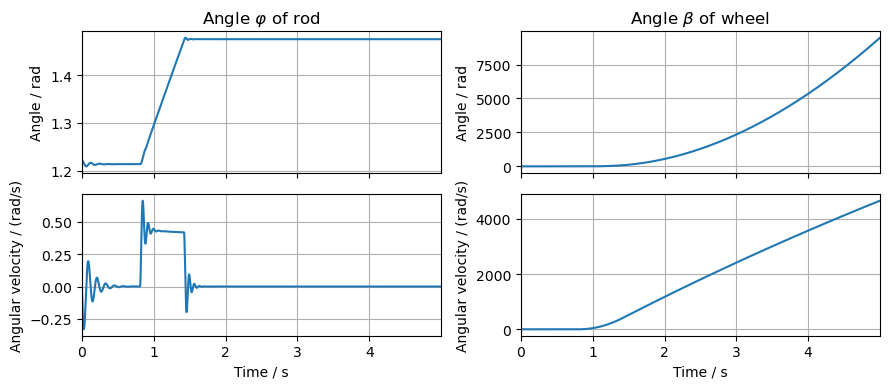

In [18]:
# scipy.integrate.solve_ivp was used as a trial to try overcoming the instability problems seen above related to the contact elasticity, without success
#from scipy.integrate import solve_ivp
import RK4
from plotter import plotTrajectories

# Initial conditions

# initial positions
# TO NOT BREAK THE MECHANISM, THE INITIAL ANGLE PHI IS DICTATED BY THE LENGTH OF THE SUSPENSION

#phi0 = phi_l_s.subs([(y_s, 1), (x_s, 0.37), (l_sr, 0.35), (l_s, 1.15)]) # rad
#print(f'With the geometrical parameters defined, at rest the mechanism angle phi is at {phi0} rad')
beta0 = 0 # rad
phi0 = np.deg2rad(70) # angle of the suspension system when no load acts on it
# initial velocities
dphi0 = 0 # rad/s
dbeta0 = 0 # rad/s

z0 = np.array([phi0,dphi0,beta0,dbeta0])

# Settings for time integration
t_sim = 5
t_span = (0, t_sim)
dt = 0.5e-3

#solution = solve_ivp(scipy_dz_fun, (0, t_sim), z0)
t_vec, z_vec = RK4.integrate(dz_fun, z0, dt, t_sim)

plotTrajectories(z_vec, t_vec)

display(z_vec.shape)


### Correcting the result, accounting for the no slip condition between tyre and ground

Remember what has already been explained above: torque from ground to the tyre acts only when there is contact AND relative velocity between ground and contact point on the tyre is not zero (so there is slippage). When the tyre tangential velocity reaches the same velocity of the ground, we will have rolling. Now the torque that the ground provides to the tyre is only the right amount to keep it spinning at the right velocity. In other words, it is the torque dissipated on the bearing. 
Since we know this without any simulation, we have decided to not implement further conditions in the contact model but instead correcting manually the results after the integration

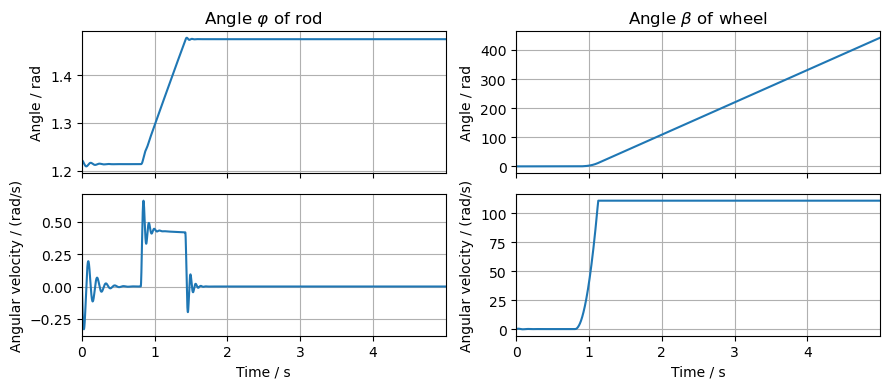

In [19]:
# correcting
z_vec, t_noslip = noslip_correction(z_vec, dt)

plotTrajectories(z_vec, t_vec)

It is clear that until the relative velocity between tyre and ground is not zero, there is slippage and consequent wear of the tyre

#### Accelerations 
Having solved the statespace, we can now compute numerically the accelerations $\ddot{\phi} $ and $\ddot{\beta}$

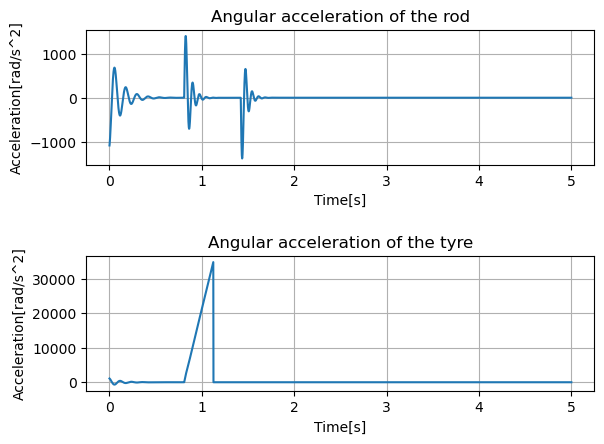

In [20]:
# define a new list of tuples with the parameters. This time we do not impose any value on the acceleration terms, as done above when solving the statespace. Because now we can compute the accelerations from our solutions

numerical_parameters = [(g, 9.81), (m_r, 7), (l_r, 0.45), (m_w, 13), (r_w, 0.3), (l_a, 0.1), (A, 0.124), (B, 0.012), (C, 0.41), (D, 0.73), (d_phi, 0.2), (d_beta, 0.05), (k_gr, 1e7), (k_ty, 80000), (d_ty, 350), (mu, 0.6), (h0, 0.7), (vel_landing_x, 33.3), (v_desc, 0.3), (phi_ref, np.deg2rad(70)), (mass_plane, 1400), (x_s, 0.37), (y_s, 1), (l_sr, 0.35), (l0, 1.15), (k_s, 80000), (c_s, 500), (sy.pi, np.pi)]

# evaluating accelerations numerically
dx = 1e-5
display(dx)
ddphi_vec = np.gradient(z_vec[1:,2], dx)    # central difference, 2nd order
ddbeta_vec = np.gradient(z_vec[1:,3],dx)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(t_vec, ddphi_vec)
axs[1].plot(t_vec, ddbeta_vec)
axs[0].set_xlabel('Time[s]')
axs[0].set_ylabel('Acceleration[rad/s^2]')
axs[1].set_xlabel('Time[s]')
axs[1].set_ylabel('Acceleration[rad/s^2]')
axs[0].set_title('Angular acceleration of the rod')
axs[1].set_title('Angular acceleration of the tyre')
axs[0].grid(True)
axs[1].grid(True)
fig.tight_layout(pad=2.0)

#plt.savefig('./figures/plots/accelerations.png')


### Giving a closer look at the contact behaviour and stresses on the tyres

⎧        ⎛⎧   0.7 - 0.3⋅t     for 0.3⋅t - 0.7 ≤ -0.273546564496551⎞           
⎪14400.0⋅⎜⎨                                                       ⎟ + 28.35⋅si
⎪        ⎝⎩0.273546564496551               otherwise              ⎠           
⎨                                                                             
⎪                                                                             
⎪                                                     0                       
⎩                                                                             

                                     ⎧   0.3⋅t + 0.45⋅cos(φ) - 0.7 ≥ -0.3     
n(φ)⋅φ̇ - 6480.0⋅cos(φ) - 4320.0  for ⎨                                       
                                     ⎩0.45⋅cos(φ) - 0.273546564496551 ≥ -0.3  
                                                                              
                                     ⎧   0.3⋅t + 0.45⋅cos(φ) - 0.7 < -0.3     
                                 for ⎨             

Time at which tyre tangential velocity matches ground velocity: 1.125
Torque on tyre at the end of simulation time: -5.550


Text(0, 0.5, 'Height of wheel center of mass [m]')

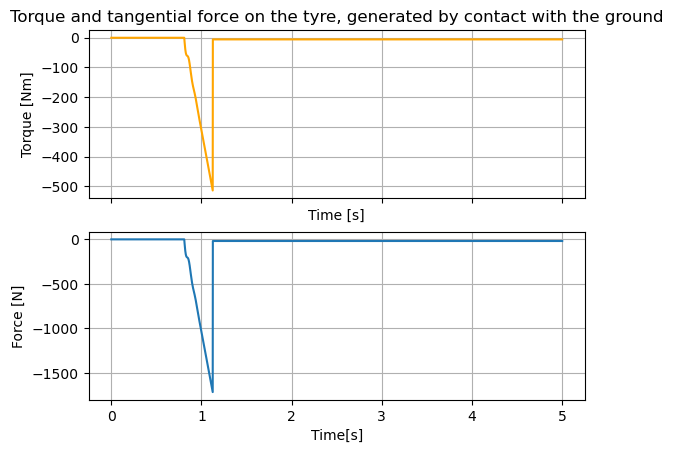

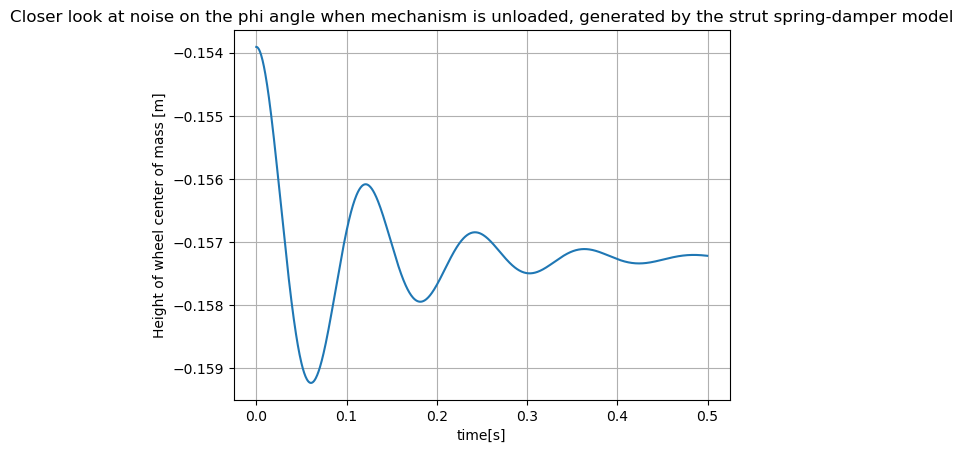

In [21]:
# TORQUE ON THE TYRE
contact_torque = M_ct.subs(numerical_parameters)
display(contact_torque)

# as function
contact_torque_fun = sy.lambdify((phi, dphi, t), contact_torque, 'numpy')
torque_vec = contact_torque_fun(z_vec[1:,0], z_vec[1:,2], t_vec[:])

# no slip correction -> when wheel velocity is equal to ground velocity, contact torque is equal to dissipation torque on roller bearing 
M_diss_beta = M_beta.subs([(d_beta, 0.05)])
M_diss_beta_fun = sy.lambdify((dbeta), M_diss_beta, 'numpy')

# converting time to index
print(f'Time at which tyre tangential velocity matches ground velocity: {t_noslip}')
idx_noslip = int(t_noslip / dt)

# correcting
torque_vec[idx_noslip:] = M_diss_beta_fun(z_vec[1:,3])[idx_noslip:]
print(f'Torque on tyre at the end of simulation time: {torque_vec[-1]:.3f}')

# FORCE ON THE TYRE
force_tan_vec = torque_vec / r_wheel

# plotting

fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(t_vec, torque_vec[:], 'orange', label='Torque')
axs[1].plot(t_vec, force_tan_vec[:], label='Force')
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_title('Torque and tangential force on the tyre, generated by contact with the ground')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Torque [Nm]')
axs[1].set_ylabel('Force [N]')
axs[1].set_xlabel('Time[s]')

#plt.savefig('./figures/plots/tyre-whear-actions.png')

l_rod = 0.45
h_vec = -l_rod* np.cos(z_vec[:1000])
fig, ax = plt.subplots()
ax.plot(t_vec[:1000], h_vec[:1000, 0])
ax.grid(True)
ax.set_title('Closer look at noise on the phi angle when mechanism is unloaded, generated by the strut spring-damper model')
ax.set_xlabel('time[s]')
ax.set_ylabel('Height of wheel center of mass [m]')



**Why do we have this initial noise?** $\phi_{ref} = 70°$ has been defined as the configuration angle when suspension is unloaded. So at this angle the strut suspension doesn't generate any force. But on the system acts gravity, so in reality this angle closes a little bit as the strut generates the right force to balance the weight of rod and wheel

## Mechanism animation

**PLEASE NOTE:**

Animating time series, where points disappear and reappear at next time step, seems to yield problems in jupyter ( rendering in the notebook instead as exploting the GUI with "%matplotlib ipympl" yields a 'tornado error'). So the numpy vector containing positions will be exported, and an external script will do the animation using the predefined GUI instead of plotting in jupyter

In [22]:
# transformation of coordinates

def xy_transform(phi, l_rod):
    # x-y coordinates of the rod
    r_cm = np.array([l_rod/2 * np.sin(phi), -l_rod/2 * np.cos(phi)]).T
    # x-y coordinates of the wheel
    w_cm = np.array([l_rod * np.sin(phi), -l_rod * np.cos(phi)]).T

    return r_cm, w_cm

#### Transforming, exporting and animating

To prevent that the notebook execution blocks here (it may), I commented out everything. Just have a look at the animation that I did on my machine, mp4 in the project folder

In [24]:
#import animate_mechanism

# coordinate transformation
#_ , xy_w_cm = xy_transform(z_vec[:,0], l_rod)

# vector exportation
#np.save('wheel_xy_position', xy_w_cm)
#display(xy_w_cm.shape)

# render animation (I really doubt it will render here in jupyter)
#animate_mechanism.animation

**Please if you want to have a look at the animation, call the script from the terminal. Depending on your matplotlib version, it could also not work. <u>I will leave a short clip in the project folder to have a look at the animation just in case your packages give you some problems </u>** 

## PART 3: Retrieving the reaction forces

It's needed to project the equations back from the reference system of minimal coordinates to the intertial (x,y,z) reference system.

**Note**:
As mentioned, mechanism is not planar, since rod and wheel are not lying in the same plane. Still, the constraints between them act in a plane (revolute joints with only 1 DOF). Therefore, first the reaction forces in the respective planes of action will be determined. At the end, moments on the joints given by the lever of the reactions (wheel) will be evaluated

In [25]:
# defining symbolic quantites
x = sy.Function('x')(t)
y = sy.Function('y')(t)

### Getting direction of the reaction force for the rod and the wheel

In [26]:
# constraint equation for the rod
f_r = x**2 + y**2 - (l_r/2)**2 

# getting direction of the reaction force (dx_f_r = "derivative of the constraint equation in x, for the rod r")
dx_f_r = sy.diff(f_r, x)
dy_f_r = sy.diff(f_r, y)

# collecting into a vector and normalizing, since it's a direction
dr_f_r =  sy.Matrix([dx_f_r, dy_f_r, 0])
dr_f_r_norm = dr_f_r / dr_f_r.norm()

# check
display(f_r, dr_f_r_norm)

# direction of wheel constraint reaction force
f_w = x**2 + y**2 - (l_r)**2 
dr_f_w = sy.Matrix([f_w.diff(x), f_w.diff(y), 0])
dr_f_w_norm = dr_f_w / dr_f_w.norm()

display(dr_f_w_norm)


⎡        2⋅x         ⎤
⎢────────────────────⎥
⎢   _________________⎥
⎢  ╱      2        2 ⎥
⎢╲╱  4⋅│x│  + 4⋅│y│  ⎥
⎢                    ⎥
⎢        2⋅y         ⎥
⎢────────────────────⎥
⎢   _________________⎥
⎢  ╱      2        2 ⎥
⎢╲╱  4⋅│x│  + 4⋅│y│  ⎥
⎢                    ⎥
⎣         0          ⎦

⎡        2⋅x         ⎤
⎢────────────────────⎥
⎢   _________________⎥
⎢  ╱      2        2 ⎥
⎢╲╱  4⋅│x│  + 4⋅│y│  ⎥
⎢                    ⎥
⎢        2⋅y         ⎥
⎢────────────────────⎥
⎢   _________________⎥
⎢  ╱      2        2 ⎥
⎢╲╱  4⋅│x│  + 4⋅│y│  ⎥
⎢                    ⎥
⎣         0          ⎦

## Note on the procedure

Intuitively we can see that the contact wheel-ground will produce a strong reaction in the hub. This will be taken by the rod and transported to the frame through the rod pin and the suspension. 

The strategy for getting the overall complete reaction is as follows:
- rod analysis, where only forces acting directly on the rod will be taken into account -> here we obtain reaction on the rod pin due to only "rod actions"
- wheel analysis, where only forces acting directly on the wheel will be taken into account -> here we obtain the entire reaction on the hub, given only by "wheel actions".

At the end, since the two reactions have the same direction, we can just sum them up algebrically to find the overall reaction on the rod pin


### Reaction forces on the suspension strut

Compression: negative sign
Tension: positive sign

Force value on the suspension strut after touchdown: -6914.0731153846
Wight of the plane was distributed on two tyres (2 suspension systems). With a mass of 1400 kg, 
the theoretical load on the single suspension strut after touchdown should be 6867.0N, in compression


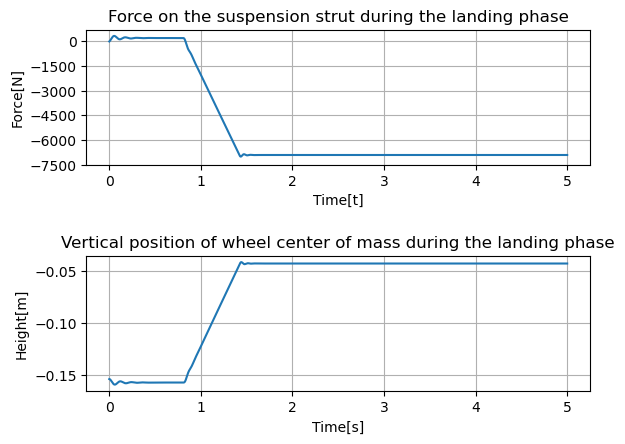

In [27]:
reaction_strut = F_s_simplif_model.subs(numerical_parameters)
display(reaction_strut)
reaction_strut_func = sy.lambdify((phi, dphi), reaction_strut, 'numpy')
reaction_strut_vector = reaction_strut_func(z_vec[1:,0], z_vec[1:,2])

fig, ax = plt.subplots(2,1)
ax[0].plot(t_vec, reaction_strut_vector)
ax[0].set_title('Force on the suspension strut during the landing phase')
ax[0].grid(True)
ax[0].set_xlabel('Time[t]')
ax[0].set_ylabel('Force[N]')
y_ticks = np.arange(0, -8001, -1500)
ax[0].set_yticks(y_ticks)

l_rod = 0.45
h_vec = -l_rod* np.cos(z_vec[:,0])
ax[1].plot(t_vec, h_vec[1:])
ax[1].grid(True)
ax[1].set_title('Vertical position of wheel center of mass during the landing phase')
ax[1].set_xlabel('Time[s]')
ax[1].set_ylabel('Height[m]')
fig.tight_layout(pad=2.0)

#plt.savefig('./figures/plots/strut-actions.png')

print(f'Force value on the suspension strut after touchdown: {reaction_strut_vector[-1]}')

print(f'Wight of the plane was distributed on two tyres (2 suspension systems). With a mass of 1400 kg, \nthe theoretical load on the single suspension strut after touchdown should be {1400/2*9.81}N, in compression')

### Reaction forces on the rod pin

Since we are interested only in the force acting at the constraint, we need only Newton equation (no Euler). Furthermore, it is to be noted that, apart the dissipation torque that we added, our hinges do not constrain any moment about z axis.
This equation can be rewritten as $m \cdot a = conservative forces + non conservative forces + reaction forces$, where we have gravity and the forces from the suspension system.

*Note that, on the rod, ground force is not acting directly, so for evaluation of reaction it must not be considered*

In [28]:
# Newton equation of motion of the rod in x-y coordinates

Lambda = sy.Function('lambda')(t)

# acceleration term
I_ddr_r = sy.diff(I_dr_r, t)

# conservative forces
Fg = m_r * g_vec

# Newton equation (2 scalar equations with one unknow lambda)
# m*a - (external forces + reaction force) = 0
Nxyz_r = m_r * I_ddr_r - (Fg + dr_f_r_norm * Lambda + I_F_s_cm_simpmodel)

# check
display(Fg, Nxyz_r)



⎡  0  ⎤
⎢     ⎥
⎢-g⋅mᵣ⎥
⎢     ⎥
⎣  0  ⎦

⎡                                     ⎛             2              ⎞          
⎢                                     ⎜  lᵣ⋅sin(φ)⋅φ̇    lᵣ⋅cos(φ)⋅φ̈⎟        
⎢                                  mᵣ⋅⎜- ──────────── + ───────────⎟ - ───────
⎢                                     ⎝       2              2     ⎠      ____
⎢                                                                        ╱    
⎢                                                                      ╲╱  4⋅│
⎢                                                                             
⎢                                                                          ⎛  
⎢                                                                          ⎜lᵣ
⎢cₛ⋅l_{sr}⋅sin(φ)⋅φ̇ + g⋅mᵣ + kₛ⋅(l_{sr}⋅cos(φ_{ref}) - l_{sr}⋅cos(φ)) + mᵣ⋅⎜─
⎢                                                                          ⎝  
⎢                                                                             
⎢                                                   

Here we notice that we have 2 equations with only 1 unknown $\lambda$, that is the magnitude of the reaction force. It is now required to project this results with the direction of the reaction force computed above

In [29]:
# Projecting Newton equation in the direction of reaction force of the first constraint
proj_Nxyz_r_costr1 = Nxyz_r.T * dr_f_r_norm

Now this unique equation can be solved for the value of $\lambda$, amplitude of the reaction force

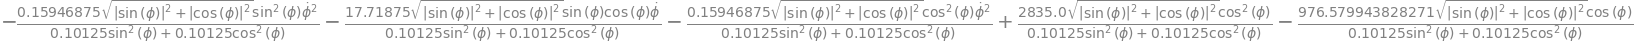

In [30]:
reaction1_symb = sy.solve(proj_Nxyz_r_costr1, Lambda, dict=True)

# substituting constant values
reaction1 = reaction1_symb[0][Lambda].subs([(x, I_r_r[0]), (y, I_r_r[1])])

reaction1 = reaction1.subs(numerical_parameters)

display(reaction1)

Force on the rod pin after landing: -663.9817852116795


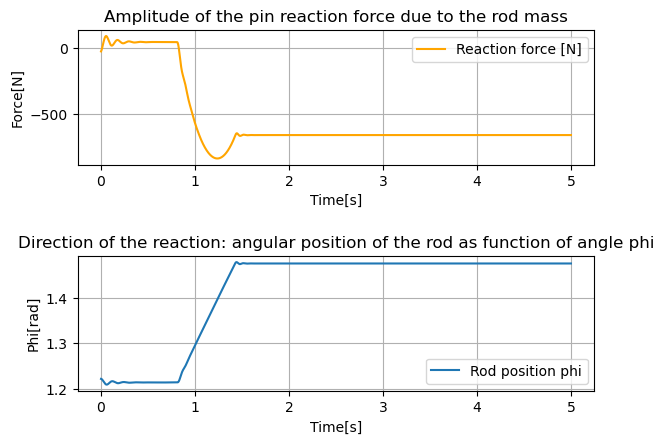

In [31]:
# Transforming algebraic expression into function
reaction1_func = sy.lambdify((phi, dphi), reaction1, "numpy")

reaction1_vec = reaction1_func(z_vec[1:,0], z_vec[1:,2])

# visualizing the reaction force over time

fig, axs = plt.subplots(2, 1)
axs[0].set_title('Amplitude of the pin reaction force due to the rod mass')
axs[0].plot(t_vec, reaction1_vec, 'orange', label='Reaction force [N]')
axs[0].set_xlabel('Time[s]')
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_ylabel('Force[N]')
axs[1].set_title('Direction of the reaction: angular position of the rod as function of angle phi')
axs[1].plot(t_vec, z_vec[1:, 0], label='Rod position phi')
axs[1].set_xlabel('Time[s]')
axs[1].set_ylabel('Phi[rad]')
axs[0].legend()
axs[1].legend()
fig.tight_layout(pad=2.0)

#plt.savefig('./figures/plots/rodpin-actions.png')

print(f'Force on the rod pin after landing: {reaction1_vec[-1]}')

Remembering how the direction of the reaction has been defined, positive from rod center of mass to the pin, it's clear that:
- Positive force = rod in traction -> before touchdown, strut suspension force is directed upwards -> rod is in tension
- Negative force = rod in compression

Dissipation torque on the rod pin

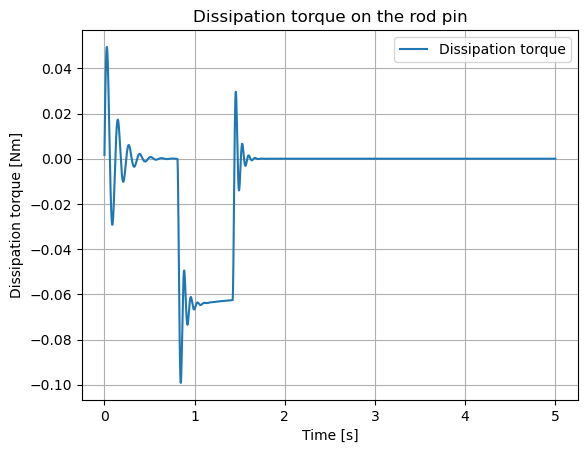

In [32]:
M_phi = M_phi.subs([(d_phi, 0.15)])
# transforming symbolic expression to a function
M_phi_fun = sy.lambdify((dphi), M_phi, 'numpy')

# calculating values of dissipation torque in time
M_phi_vec = M_phi_fun(z_vec[1:, 2])

# visualizing dissipation torque in time
fig, ax = plt.subplots()
ax.plot(t_vec, M_phi_vec, label='Dissipation torque')
ax.set_title('Dissipation torque on the rod pin')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Dissipation torque [Nm]')
#ax.plot(t_vec, z_vec[1:, 0], label='phi position of the rod')
ax.legend()
plt.grid(True)



### Reaction forces on the wheel hub
As previously mentioned, wheel and its hub are not in the same plane. This yields a moment on both wheel hub and rod pin. Now the 'planar' force will be evaluated with the same approach as before. Afterwards the moments will be computed.

**IMPORTANT:**
Again we are interested in the forces, not in the reaction moments (given only by the dissipation torque on the bearing). 
So again only Newton equation will be employed 

In [33]:
# Newton equation of motion of the wheel in x-y coordinates
Lambda = sy.Symbol('lambda')
# acceleration term
I_ddr_w = sy.diff(I_dr_w, t)

# conservative forces
Fg = m_w * g_vec

# ground force 
F_contact = sy.Matrix([0, -F_ct, 0])

# tangential force on tyre due to contact (consistent during the slippage phase)
force_tan_tyre = sy.Matrix([-contact_torque/r_w, 0, 0]) 

# Newton equation (2 scalar equations with one unknow lambda) - Note the presence of the ground forces now, but as explained below we must take them out due to some problems with the solver
# m*a - (external forces + reactions) = 0
Nxyz_w = m_w * I_ddr_w - (Fg + dr_f_w_norm * Lambda)#  + force_tan_tyre #- F_contact

# check
display(Fg, Nxyz_w)



⎡  0   ⎤
⎢      ⎥
⎢-g⋅m_w⎥
⎢      ⎥
⎣  0   ⎦

⎡           2⋅λ⋅x               ⎛             2              ⎞  ⎤
⎢  - ──────────────────── + m_w⋅⎝- lᵣ⋅sin(φ)⋅φ̇  + lᵣ⋅cos(φ)⋅φ̈⎠  ⎥
⎢       _________________                                       ⎥
⎢      ╱      2        2                                        ⎥
⎢    ╲╱  4⋅│x│  + 4⋅│y│                                         ⎥
⎢                                                               ⎥
⎢               2⋅λ⋅y               ⎛                         2⎞⎥
⎢g⋅m_w - ──────────────────── + m_w⋅⎝lᵣ⋅sin(φ)⋅φ̈ + lᵣ⋅cos(φ)⋅φ̇ ⎠⎥
⎢           _________________                                   ⎥
⎢          ╱      2        2                                    ⎥
⎢        ╲╱  4⋅│x│  + 4⋅│y│                                     ⎥
⎢                                                               ⎥
⎣                               0                               ⎦

**PLEASE NOTE:** Here we have $F_{contact}$ and $force_{tan_{tyre}}$ that are piecewise functions. The fact that the ITE (if-then-else) object depends upon the time $t$ represents a problem for the solver, which when called yields an 'ITE object has no attribute n' error (you can have a try decommenting the right part in the code above). Since I don't find any solution on the internet, I decide here to work around the problem as follows:
1. solve with the procedure already used above for the rod the Newton equation of the wheel, without the action of the contact force (which gives the problem) -> so the reaction to the "wheel effects" can be obtained
2. lambdify the piecewise time dependent expression for the contact force (and the tangential force that comes out of it) and evaluate the solution vector. Then project this vector on the direction

**Since in 1 we expect very small forces wrt 2 (because in 1, having removed the forces from the contact, we would have only gravity as external force), I proceed transcuring it and evaluating only the reaction due to the contact**

### Solving only for the contact

Vertical contact force after the landing: 5539.477423076933[N]


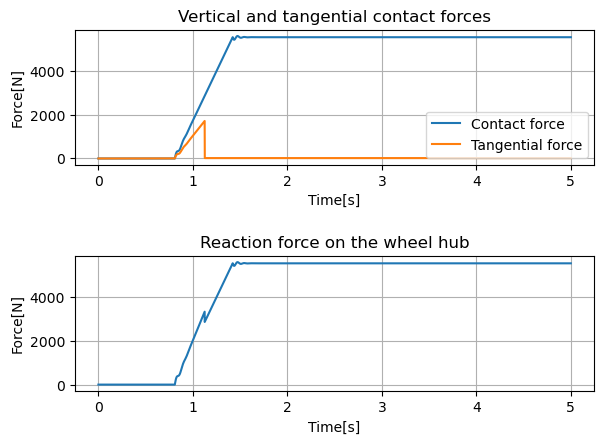

In [34]:
# vertical contact
F_ct_num = F_ct.subs(numerical_parameters)
# tangential force from contact
force_tan_vec = - force_tan_vec

# lambdifying
F_ct_fun = sy.lambdify((phi, dphi, t), F_ct_num, 'numpy')

# evaluating the solutions (changing sign since the force points downwards)
F_ct_vec = - F_ct_fun(z_vec[1:,0], z_vec[1:,2], t_vec)

# total force as a combination of the 2
reaction_wheelhub_vec = np.sqrt(F_ct_vec**2 + force_tan_vec**2)

# visualizing
fig, axs = plt.subplots(2,1)
axs[1].plot(t_vec, reaction_wheelhub_vec, label='Complete reaction force')
axs[1].grid(True)
axs[1].set_xlabel('Time[s]')
axs[1].set_ylabel('Force[N]')
axs[1].set_title('Reaction force on the wheel hub')
axs[0].plot(t_vec, F_ct_vec, label='Contact force')
axs[0].plot(t_vec, force_tan_vec, label='Tangential force')
axs[0].set_xlabel('Time[s]')
axs[0].set_ylabel('Force[N]')
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('Vertical and tangential contact forces')
fig.tight_layout(pad=2.0)

#plt.savefig('./figures/plots/wheelhub-actions.png')


print(f'Vertical contact force after the landing: {F_ct_vec[-1]}[N]')

When tyre tangential velocity reaches the velocity of the landing, the tangential force on the hub drops. Contact force instead increases until all the mass of the plane is discharged on the ground

Dissipation torque on the wheel hub

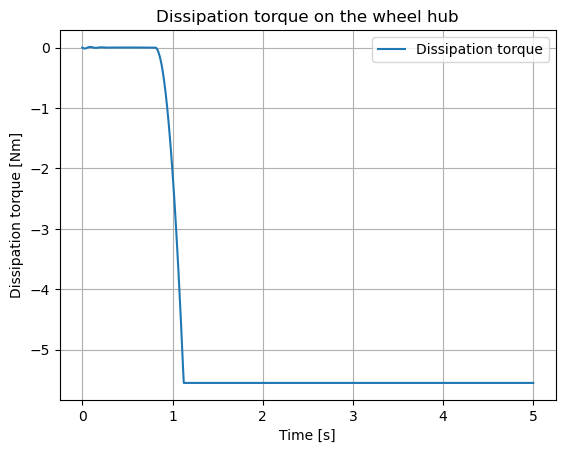

In [35]:

M_beta = M_beta.subs([(d_beta, 0.05)])
# transforming symbolic expression to a function
M_beta_fun = sy.lambdify((dbeta), M_beta, 'numpy')

# calculating values of dissipation torque in time
M_beta_vec = M_beta_fun(z_vec[1:, 3])

# visualizing dissipation torque in time
fig, ax = plt.subplots()
ax.plot(t_vec, M_beta_vec, label='Dissipation torque')
ax.set_title('Dissipation torque on the wheel hub')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Dissipation torque [Nm]')
#ax.plot(t_vec, z_vec[1:, 0], label='phi position of the rod')
ax.legend()
plt.grid(True)



## Reactions moments on the joints

#### Reaction moments on wheel hub

Previously computed reaction on wheel hub has a lever wrt the hub itself. So 2 moments, around x, and y axis of the inertia frame, will develop

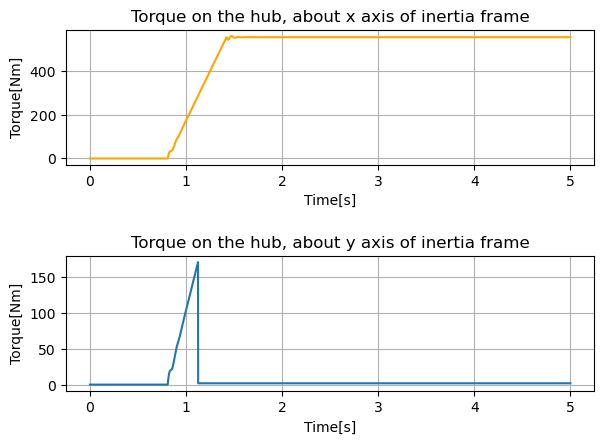

In [44]:
# remembering the width of the wheel (fixed above in the "parameters" section)
width_wheel = 0.2

# moment on the hub about inertial frame x axis (given by y component of the reaction)
reaction_moment_x_hub = F_ct_vec * width_wheel/2

# moment on the hub about inertial frame y axis
reaction_moment_y_hub = force_tan_vec * width_wheel/2


fig, axs = plt.subplots(2, 1)
axs[0].set_title('Torque on the hub, about x axis of inertia frame')
axs[0].plot(t_vec, reaction_moment_x_hub, 'orange')
axs[0].grid(True)
axs[0].set_xlabel('Time[s]')
axs[0].set_ylabel('Torque[Nm]')
axs[1].grid(True)
axs[1].set_title('Torque on the hub, about y axis of inertia frame')
axs[1].plot(t_vec, reaction_moment_y_hub)
axs[1].set_xlabel('Time[s]')
axs[1].set_ylabel('Torque[Nm]')
fig.tight_layout(pad=2.0)

plt.savefig('./figures/plots/wheelhub-torques.png')



#### Reaction moments on the rod pin

Only actions from the wheel have a lever arm. So *reaction moments on the rod pin are the same as those on the wheel hub*